# Notes on Pandas Data Cleaning

#### Author: Adam Jaamour
#### 07/10/2020

https://www.kaggle.com/learn/data-cleaning

In [1]:
import datetime

import chardet

from fuzzywuzzy import fuzz, process
import matplotlib.pyplot as plt
from mlxtend.preprocessing import minmax_scaling
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns

np.random.seed(0) 

# Handling Missing Values

## Initial look at the data

In [2]:
# https://www.kaggle.com/agirlcoding/all-space-missions-from-1957
# Detail: Rocket Name
# Rocket column: Cost of the mission: in $ million
df = pd.read_csv("data/space-missions/Space_Corrected.csv")

Initial visualisation of the data

In [3]:
df.head()

,Unnamed: 0,Unnamed: 0.1,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,NaN,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.00,Success


Count how many missing data points 

In [4]:
missing_values = df.isnull().sum()
missing_values

Unnamed: 0           0
Unnamed: 0.1         0
Company Name         0
Location             0
Datum                0
Detail               0
Status Rocket        0
 Rocket           3360
Status Mission       0
dtype: int64

See what percentage of the values in our dataset are missing to give us a better sense of the scale of this problem

In [5]:
# how many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = missing_values.sum()
print("total cells = {}\ntotal missing = {}".format(total_cells, total_missing))

# percent of data that is missing
print("% missing = {}%".format(round((total_missing / total_cells) * 100, 2)))

total cells = 38916
total missing = 3360
% missing = 8.63%


**Is this value missing because it wasn't recorded or because it doesn't exist?**:

* if a value is missing becuase it doesn't exist then it doesn't make sense to try and guess what it might be (keep as NaN)

* if a value is missing because it wasn't recorded, then can try to guess what it might have been based on the other values in that column and row (imputation)

## Option 1: drop missing values

If in a hurry or don't have a reason to figure out why values are missing, can remove any rows or columns that contain missing values. 

*Note: not recommend to follow this approch for important projects! It's usually worth it to take the time to go through data and really look at all the columns with missing values one-by-one to really get to know the dataset.)*

In [6]:
# remove all the rows that contain a missing value
print("dataframe size before dropping values={}".format(df.shape))
df.dropna()
print("dataframe size after dropping values={}".format(df.shape))

dataframe size before dropping values=(4324, 9)
dataframe size after dropping values=(4324, 9)


Danger: might delete all data (if each row contains at least 1 missing value)

In [7]:
# remove all columns with at least one missing value
columns_with_na_dropped = df.dropna(axis=1)
columns_with_na_dropped.head()
print("Columns in original dataset: {}".format(df.shape[1]))
print("Columns with na's dropped: {}".format(columns_with_na_dropped.shape[1]))

Columns in original dataset: 9
Columns with na's dropped: 8


--> Lost 1 column, but no more NaN in data

## Option 2: Filling in missing values automatically

Replace all the NaN values with 0.

In [8]:
# replace all NA's with 0
df.fillna(0)

,Unnamed: 0,Unnamed: 0.1,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,0.00,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.00,Success
...,...,...,...,...,...,...,...,...,...
4319,4319,4319,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Wed Feb 05, 1958 07:33 UTC",Vanguard | Vanguard TV3BU,StatusRetired,0.00,Failure
4320,4320,4320,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA","Sat Feb 01, 1958 03:48 UTC",Juno I | Explorer 1,StatusRetired,0.00,Success
4321,4321,4321,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Fri Dec 06, 1957 16:44 UTC",Vanguard | Vanguard TV3,StatusRetired,0.00,Failure
4322,4322,4322,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan","Sun Nov 03, 1957 02:30 UTC",Sputnik 8K71PS | Sputnik-2,StatusRetired,0.00,Success


Replace all values with whatever value comes directly after it in the same column. 
*(This makes a lot of sense for datasets where the observations have some sort of logical order to them.)*

In [9]:
df = pd.read_csv("data/space-missions/Space_Corrected.csv")
# replace all NA's the value that comes directly after it in the same column, 
# then replace all the remaining na's with 0
df.fillna(method="bfill", axis=0).fillna(0)

,Unnamed: 0,Unnamed: 0.1,Company Name,Location,Datum,Detail,Status Rocket,Rocket,Status Mission
0,0,0,SpaceX,"LC-39A, Kennedy Space Center, Florida, USA","Fri Aug 07, 2020 05:12 UTC",Falcon 9 Block 5 | Starlink V1 L9 & BlackSky,StatusActive,50.00,Success
1,1,1,CASC,"Site 9401 (SLS-2), Jiuquan Satellite Launch Ce...","Thu Aug 06, 2020 04:01 UTC",Long March 2D | Gaofen-9 04 & Q-SAT,StatusActive,29.75,Success
2,2,2,SpaceX,"Pad A, Boca Chica, Texas, USA","Tue Aug 04, 2020 23:57 UTC",Starship Prototype | 150 Meter Hop,StatusActive,65.00,Success
3,3,3,Roscosmos,"Site 200/39, Baikonur Cosmodrome, Kazakhstan","Thu Jul 30, 2020 21:25 UTC",Proton-M/Briz-M | Ekspress-80 & Ekspress-103,StatusActive,65.00,Success
4,4,4,ULA,"SLC-41, Cape Canaveral AFS, Florida, USA","Thu Jul 30, 2020 11:50 UTC",Atlas V 541 | Perseverance,StatusActive,145.00,Success
...,...,...,...,...,...,...,...,...,...
4319,4319,4319,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Wed Feb 05, 1958 07:33 UTC",Vanguard | Vanguard TV3BU,StatusRetired,0.00,Failure
4320,4320,4320,AMBA,"LC-26A, Cape Canaveral AFS, Florida, USA","Sat Feb 01, 1958 03:48 UTC",Juno I | Explorer 1,StatusRetired,0.00,Success
4321,4321,4321,US Navy,"LC-18A, Cape Canaveral AFS, Florida, USA","Fri Dec 06, 1957 16:44 UTC",Vanguard | Vanguard TV3,StatusRetired,0.00,Failure
4322,4322,4322,RVSN USSR,"Site 1/5, Baikonur Cosmodrome, Kazakhstan","Sun Nov 03, 1957 02:30 UTC",Sputnik 8K71PS | Sputnik-2,StatusRetired,0.00,Success


# Scaling and Normalisation

* scaling = changing the range of your data
* normalisation = changing the shape of the distribution of your data.

## Scaling

==> transforming your data so that it fits within a specific scale

Useful when using methods based on measures of how far apart data points are, like SVM or kNN --> can help compare different variables on equal footing.

In [10]:
# generate 1000 data points randomly drawn from an exponential distribution
data = np.random.exponential(size=1000)

# df[" Rocket"].to_numpy()
# data

In [11]:
# mix-max scale the data between 0 and 1
scaled_data = minmax_scaling(data, columns=[0])

Text(0.5, 1.0, 'Scaled data')

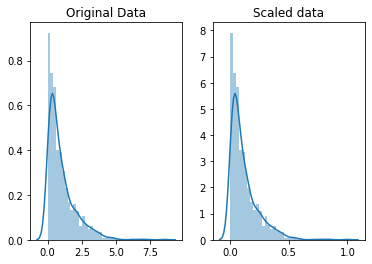

In [12]:
# plot both together to compare
fig, ax = plt.subplots(1,2)
sns.distplot(data, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(scaled_data, ax=ax[1])
ax[1].set_title("Scaled data")

## Normalisation

The point of normalisation is to change observations so that they can be described as a normal distribution != scaling!

**Normalisation** = specific statistical distribution where 
* roughly equal observations fall above and below the mean
* the mean and the median are the same
* there are more observations closer to the mean
* aka *Gaussian distribution* and *bell curve*.

Normalise your data if going to be using a machine learning or statistics technique that assumes that the data is normally distributed e.g. linear discriminant analysis (LDA) and Gaussian naive Bayes (any method with "Gaussian" in the name probably assumes normality.)

In [13]:
# normalize the exponential data with a boxcox transformation
normalized_data = stats.boxcox(data)

Text(0.5, 1.0, 'Normalized data')

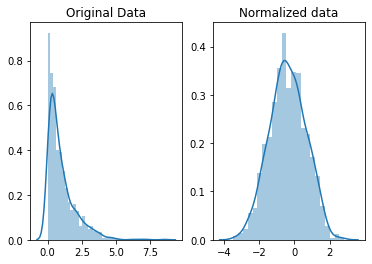

In [14]:
# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(data, ax=ax[0])
ax[0].set_title("Original Data")
sns.distplot(normalized_data[0], ax=ax[1])
ax[1].set_title("Normalized data")

--> the shape of data has changed. Before normalising it was almost L-shaped. But after normalizing it looks more like the outline of a bell.

# Parsing Dates

Dates are in `Datum` columns (Strings usually have type object)

In [15]:
df['Datum'].head()

0    Fri Aug 07, 2020 05:12 UTC
1    Thu Aug 06, 2020 04:01 UTC
2    Tue Aug 04, 2020 23:57 UTC
3    Thu Jul 30, 2020 21:25 UTC
4    Thu Jul 30, 2020 11:50 UTC
Name: Datum, dtype: object

Convert column to datetime using strftime directives: https://strftime.org/ to point out which parts of the date are where and what punctuation is between them e.g. `%d` for day, `%m` for month, `%y` for a two-digit year and `%Y` for a four digit year:
* 1/17/07 has the format `%m/%d/%y`
* 17-1-2007 has the format `%d-%m-%Y`



(use infer_datetime_format if run into an error with multiple date formats)

In [16]:
df['Datum'] = pd.to_datetime(df['Datum'], utc=True)  # infer_datetime_format=True
df['Datum'].head()

0   2020-08-07 05:12:00+00:00
1   2020-08-06 04:01:00+00:00
2   2020-08-04 23:57:00+00:00
3   2020-07-30 21:25:00+00:00
4   2020-07-30 11:50:00+00:00
Name: Datum, dtype: datetime64[ns, UTC]

--> Now dtype is datetime64

Can now interact with dates e.g. extract information from the day the launch occured

In [17]:
day_of_launch = df['Datum'].dt.day
day_of_launch.head()

0     7
1     6
2     4
3    30
4    30
Name: Datum, dtype: int64

Plotting days of the month because there is a danger with parsing dates: mixing up the months and days.

It is better to double-check that the days of the month make sense (plot a histogram of the days of the month, expect values between 1 and 31):

<AxesSubplot:xlabel='Datum'>

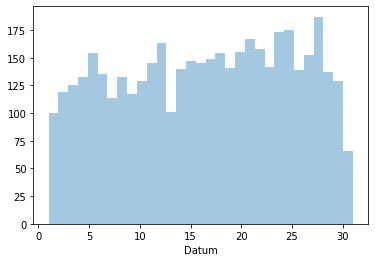

In [18]:
day_of_launch = day_of_launch.dropna()
sns.distplot(day_of_launch, kde=False, bins=31)

# Character Encodings

## Encodings

Character encodings are specific sets of rules for mapping from raw binary byte strings (that look like this: 0110100001101001) to characters that make up human-readable text (like "hi"). There are many different encodings, and if anyone tried to read in text with a different encoding than the one it was originally written in, you ended up with:
* scrambled text called "mojibake" e.g. `æ–‡å—åŒ–ã??`
* a "unknown" characters. They are what gets printed when there's no mapping between a particular byte and a character in the encoding you're using to read your byte string in and they look like this: `����������`

Character encoding mismatches are less common today than they used to be, but it's definitely still a problem. There are lots of different character encodings. The main one is UTF-8, the standard text encoding. All Python code is in UTF-8 and ideally all the data should be as well. Trouble comes when UTF-8 is not used.

There are two main data types when working with text in Python 3: string and bytes.

### String

`string` which is what text is by default

In [19]:
# string with a symbol:
my_str = "This is the euro symbol: €"
type(my_str)

str

### Byte

`bytes` is a sequence of integers (can convert a string into bytes by specifying which encoding it's in)

In [20]:
# encode previous string it to a different encoding, replacing characters that raise errors:
new_str = my_str.encode("utf-8", errors="replace")
type(new_str)

bytes

The bytes object has a `b` in front of it and some text after. That's because bytes are printed out as if they were characters encoded in ASCII (an older character encoding that doesn't work for writing any language other than English.) The euro symbol has been replaced with some mojibake when it's printed as if it were an ASCII string.

In [21]:
new_str

b'This is the euro symbol: \xe2\x82\xac'

Can convert bytes back to a string with the correct encoding to get the correct text.

In [22]:
print(new_str.decode("utf-8"))

This is the euro symbol: €


Can try decoding in ASCII instead of UTF-8, but will cause errors because the encoding trying to use doesn't know what to do with the bytes trying to pass it --> need to tell Python the encoding that the byte string is actually supposed to be in:

In [23]:
print(new_str.decode("ascii"))

UnicodeDecodeError: 'ascii' codec can't decode byte 0xe2 in position 25: ordinal not in range(128)

Can ask for the bytes to be what they would be if the text was in ASCII. Since text isn't in ASCII there will be some characters it can't handle which are  automatically replaced with the unknown character. When the bytes are converted back to a string, the character will be replaced with the unknown character `�`. The dangerous part about this is that there's not way to tell which character it should have been --> just made data unusable!

In [24]:
before = "This is the euro symbol: €"
# Encode string to a different encoding (ASCII instead of UTF-8), replacing characters that raise errors
after = before.encode("ascii", errors = "replace")
# Convert it back to utf-8
print(after.decode("ascii"))

This is the euro symbol: ?


It's better to convert all text to UTF-8 ASAP and keep it in that encoding. The best time to convert non UTF-8 input into UTF-8 during file reading.

## Reading in files with encoding problems

If get `UnicodeDecodeError` error (same when  tried to decode UTF-8 bytes as if they were ASCII), then file isn't actually UTF-8. 

In [25]:
df_in = pd.read_csv("data/pakistan-intellectual-capital/Pakistan Intellectual Capital - Computer Science - Ver 1.csv")

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa0 in position 20: invalid start byte

Don't know what encoding it actually is so can use the `chardet` module to try and automatically guess what the right encoding is (not 100% guaranteed to be right, but faster than just trying to guess).

In [26]:
# Look at the first ten thousand bytes to guess the character encoding (usually enough for a good guess)
with open("data/pakistan-intellectual-capital/Pakistan Intellectual Capital - Computer Science - Ver 1.csv", 'rb') as rawdata:
    result = chardet.detect(rawdata.read(10000))

# Check what the character encoding might be
print(result)

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [27]:
df_in = pd.read_csv("data/pakistan-intellectual-capital/Pakistan Intellectual Capital - Computer Science - Ver 1.csv", encoding=result["encoding"])

## Saving file in UTF-8 encoding

Once file is in UTF-8, save it in that encoding. Easily done by saving file because it will be saved as UTF-8 by default.

In [28]:
df_in.to_csv("data/pakistan-intellectual-capital/Pakistan Intellectual Capital - Computer Science - Ver 1 - utf8.csv")

## E) Inconsistent Data Entry

In [29]:
df = pd.read_csv("data/pakistan-intellectual-capital/Pakistan Intellectual Capital - Computer Science - Ver 1 - utf8.csv")
df.head(3)

,Unnamed: 0,S#,Teacher Name,University Currently Teaching,Department,Province University Located,Designation,Terminal Degree,Graduated from,Country,Year,Area of Specialization/Research Interests,Other Information
0,0,1,Dr. Ihsan Ullah,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,NaN,France,NaN,"P2P Networks, Telecommunication Systems",NaN
1,1,2,Dr. Atiq Ahmed,University of Balochistan,Computer Science & IT,Balochistan,Associate Professor,PhD,NaN,France,NaN,"Wireless Networks, Telecommunication Systems, ...",NaN
2,2,3,Dr. Abdul Basit,University of Balochistan,Computer Science & IT,Balochistan,Assistant Professor,PhD,Asian Institute of Technology,Thailand,NaN,Software Engineering & DBMS,NaN


In [30]:
df["Country"].unique()

array(['France', 'Thailand', nan, 'Italy', 'Pakistan', 'Germany',
       'Austria', 'Australia', 'UK', 'China', 'USA', 'South Korea',
       'Malaysia', 'Sweden', 'Canada', 'Norway', 'Ireland', 'New Zealand',
       'Urbana', 'Portugal', 'Russian Federation', 'Finland', ' USA',
       'Netherland', ' Germany', ' Sweden', ' New Zealand', 'Greece',
       'Turkey', 'Macau', 'Singapore', 'Spain', 'Denmark', 'Japan',
       'HongKong', 'Saudi Arabia', 'Mauritius', 'Scotland'], dtype=object)

Inconsistencies: " New Zealand" and "New Zealand" or "Germany" and " Germany" (leading space).

--> make everything lower case (can change it back later) and remove any white spaces at the beginning and end of cells. Inconsistencies in capitalisations and trailing white spaces are very common in text data.

In [31]:
# Convert to lower case
df["Country"] = df["Country"].str.lower()
# Remove trailing white spaces
df["Country"] = df["Country"].str.strip()
df["Country"].unique()

array(['france', 'thailand', nan, 'italy', 'pakistan', 'germany',
       'austria', 'australia', 'uk', 'china', 'usa', 'south korea',
       'malaysia', 'sweden', 'canada', 'norway', 'ireland', 'new zealand',
       'urbana', 'portugal', 'russian federation', 'finland',
       'netherland', 'greece', 'turkey', 'macau', 'singapore', 'spain',
       'denmark', 'japan', 'hongkong', 'saudi arabia', 'mauritius',
       'scotland'], dtype=object)

Other inconsistency: "south korea" and "southkorea"

Going to use the `fuzzywuzzy` package to help identify which strings are closest to each other (could correct errors by hand, but that approach doesn't scale well)

**Fuzzy matching** = The process of automatically finding text strings that are very similar to the target string. In general, a string is considered "closer" to another one the fewer characters you'd need to change if you were transforming one string into another. So "apple" and "snapple" are two changes away from each other (add "s" and "n") while "in" and "on" and one change away (rplace "i" with "o"). Can't rely on fuzzy matching 100%, but will save time.

Fuzzywuzzy returns a ratio given two strings. The closer the ratio is to 100, the smaller the edit distance between the two strings. 

Example: get the 10 strings from list of countries that have the closest distance to "south korea".

In [32]:
# Get the top 10 closest matches to "south korea"
matches = process.extract("south korea", df["Country"].unique(), limit=10, scorer=fuzz.token_sort_ratio)
matches

[('south korea', 100),
 ('saudi arabia', 43),
 ('norway', 35),
 ('austria', 33),
 ('ireland', 33),
 ('pakistan', 32),
 ('portugal', 32),
 ('scotland', 32),
 ('australia', 30),
 ('singapore', 30)]

1 of the items in the countries is very close to "south korea": "southkorea". 

Now, can replace all rows in "Country" column that have a ratio of > 47 with "south korea":

In [35]:
def replace_matches_in_column(df, column, string_to_match, min_ratio = 47):
    """
    Function to replace rows in the provided column of the provided dataframe that match 
    the provided string above the provided ratio with the provided string.
    """
    # get a list of unique strings
    strings = df[column].unique()
    
    # get the top 10 closest matches to our input string
    matches = process.extract(string_to_match, 
                              strings, 
                              limit=10, 
                              scorer=fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print("Replacements completed")

In [36]:
# use the function we just wrote to replace close matches to "south korea" with "south korea"
replace_matches_in_column(df=df, column='Country', string_to_match="south korea")

Replacements completed


In [37]:
df["Country"].unique()

array(['france', 'thailand', nan, 'italy', 'pakistan', 'germany',
       'austria', 'australia', 'uk', 'china', 'usa', 'south korea',
       'malaysia', 'sweden', 'canada', 'norway', 'ireland', 'new zealand',
       'urbana', 'portugal', 'russian federation', 'finland',
       'netherland', 'greece', 'turkey', 'macau', 'singapore', 'spain',
       'denmark', 'japan', 'hongkong', 'saudi arabia', 'mauritius',
       'scotland'], dtype=object)

Only one entry for "south korea" now!

In [38]:
# Can capitalise the countries again
df['Country'] = df['Country'].str.capitalize()
df["Country"].unique()

array(['France', 'Thailand', nan, 'Italy', 'Pakistan', 'Germany',
       'Austria', 'Australia', 'Uk', 'China', 'Usa', 'South korea',
       'Malaysia', 'Sweden', 'Canada', 'Norway', 'Ireland', 'New zealand',
       'Urbana', 'Portugal', 'Russian federation', 'Finland',
       'Netherland', 'Greece', 'Turkey', 'Macau', 'Singapore', 'Spain',
       'Denmark', 'Japan', 'Hongkong', 'Saudi arabia', 'Mauritius',
       'Scotland'], dtype=object)